In [1]:
import rr_python_sdk as sdk
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
head = sdk.MeasurmentHead(port = "COM11")
head.read_all_input()

b''

# Test all functions
 (In order they are in the microcontroller code)

## Angle setting

In [3]:
head.set_angle(10)

b'\x15'


## Echo input

In [4]:
head.echo(b"Hello")

b'<<BHello'

## Read and write config data
Note, the default config will be reloaded when the device restarts

In [5]:
config = head.read_config_data()
config.microsteps_per_step

8

In [6]:
config.t_force_scale

-26.611328125

In [7]:
config.microsteps_per_step = 8

In [8]:
head.update_config_data(config)

True

In [9]:
config = head.read_config_data()

In [10]:
config.microsteps_per_step

8

## Data streaming

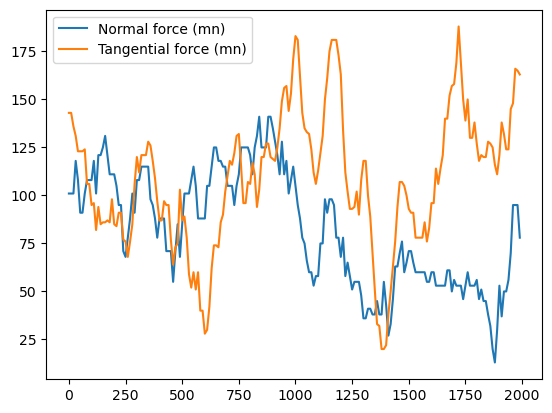

In [11]:
i = 0
points = []
head.read_all_input()
head.start_streaming_force_data(100)
while (i<200):
    points.append(head.read_force_data_point_from_stream())
    i+=1
head.stop_streaming_force_data()
#plt.plot([p.ms_since_start for p in points], [p.f_t_mn/p.f_n_mn for p in points], label="mu")
plt.plot([p.ms_since_start for p in points], [p.f_n_mn for p in points], label="Normal force (mn)")
plt.plot([p.ms_since_start for p in points], [p.f_t_mn for p in points], label="Tangential force (mn)")
plt.legend()

In [12]:
head.stop_streaming_force_data()
head.read_all_input()

b'<<\x06\x06\xd0\x07K\x00\x00\x00\xa3\x00\x00\x00'

## Show and reset error data

In [13]:
f"{head.read_error_status():016b}"

'0000000000000000'

In [14]:
head.clear_error_status()

True

## Setting target force

In [15]:
head.set_target_force(100000)

True

## Home

In [16]:
head.home()

True

## Jog

In [17]:
head.jog(100)

True

## Toggle LEDS

In [18]:
head.toggle_led(True)
time.sleep(0.5)
head.toggle_led(False)
time.sleep(0.5)
head.toggle_led(True)
time.sleep(0.5)
head.toggle_led(False)

True

## Change state to None

In [19]:
head.stop_all()

True

## Send current data

In [20]:
head.read_single_force_data_point()

ForceDataPoint(device_status=1542, ms_since_start=0, f_n_mn=426, f_t_mn=8)

## Restart

In [75]:
head.restart()

True

In [14]:
head.read_all_input()

## Start test

In [21]:
head.maintain_force(100000)

True

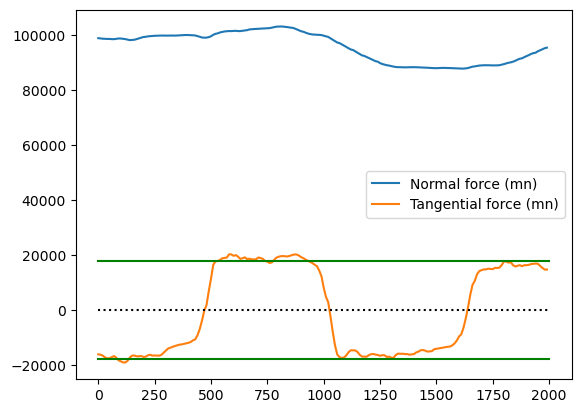

In [22]:
i = 0
points = []
head.read_all_input()
head.start_streaming_force_data(100)
while (i<200):
    points.append(head.read_force_data_point_from_stream())
    i+=1
head.stop_streaming_force_data()

centre=0
vals = np.sort([p.f_t_mn for p in points])
span = np.mean(vals[-50:])-np.mean(vals[:50])
plt.plot([p.ms_since_start for p in points], [p.f_n_mn for p in points], label="Normal force (mn)")
plt.plot([p.ms_since_start for p in points], [p.f_t_mn for p in points], label="Tangential force (mn)")
plt.plot([0,2000], [centre, centre], 'k:')
plt.plot([0,2000], [centre-span/2, centre-span/2], 'g-')
plt.plot([0,2000], [centre+span/2, centre+span/2], 'g-')
plt.legend()

In [23]:
head.stop_all()

True

## Zero all forces

In [24]:
head.home()

True

In [25]:
head.zero_forces()

True